# Calculating Equilibrium FX

You can choose any currency pair you want.
You calculate the equilibrium FX for your local currency.

1. Indicate economic theories and models for calculating equilibrium FX.
2. Indicate macroeconomic variables used for calculating equilibrium FX.
3. Explain the connection between linear regression and Vector Error Correction (VEC).
4. Calculate equilibrium FX using VEC. You can use the Behavioural Equilibrium Exchange Rate (BEER) approach. Comment results.

### Indicate economic theories and models for calculating equilibrium FX.

The equilibirum foreign exchange (FX) rate is determined by the demand and supply of one currency given another. This value can be determined by the intersection between the demand curve and the supply curve of the currency pair.

![Equlibrium FX Rate](assets/equilibrium_fx.png)

In the example given by Khan Academy[1], we can see that the exchange rate between Peso and Euro is defined by:

- Different amount of Euros supplied at different rate of Peso per Euro, forming the supply curve
- Different amount of Euros demanded at different rate of Peso per Euro, forming the demand curve

The intersection of these two curves determine the equilibrium FX rate between Peso and Euro:

- A rate higher than the equilibrium will result in the supply of Euros to exceed the demand, applying a downward pressure in the rate, towards short-term equilibrium.
- A rate lower than the equilibirum will result in the demand of Eruos to exceed the supply, applying a upward pressure in the rate, towards short-term equilibirum.

## Indicate macroeconomic variables used for calculating equilibrium FX.

Macroeconomic variables which affects the demand or supply curve of the one currency, expressed in another will affect the equilibrium FX rate.

### Interest Rates

One such example is the interest rate of a country. When interest rates increases, savers from other countries will be encouraged to buy financial assets in that country[1]. That will require foreign savers to first buy the country's currency to buy the financial assets. This results in higher demand for the country's currency, resulting in increased exhange rate. 

Factors increasing interest rate can include the country's budget deficit. 

### Money Supply

The money supply of the country affects the supply of the currency directly. An increase in money supply results in a decrease in equilibrium FX[2].

One metrics that is available is M1 which directly measures physical currency and coin, demand deposits, travelers checks, other checkable deposits and negotiable order of withdrawal (NOW) accounts[3]. Basically, the most liquid form of money in a country.

### Inflation

Typically, a country with a consistently lower inflation rate exhibits a rising currency value, as its purchasing power increases relative to other currencies. [4]

### Industrial Production Index 

The Index of Industrial Production (IIP) has shown to be dependent on the exchange rate[5].

### Political Stability

Political stability of a country also affects the exchange rate positively. Investors are encouraged to invest in countries with higher political stability, resulting in higher demand for the currency[4].

## Explain the connection between linear regression and Vector Error Correction (VEC).

The Vector Auto-Regressive(VAR) model extends the linear regression model by allowing different processes to be grenerated from their mutual histories. 

![VAR](assets/var.png)

The VAR equation is produce the generating process based on previous period values, producing a short term forecasting result.  

The Vector Error Correction (VEC) model, also known as cointegration model, extends the VAR model. It introduces the long-term relationships between variables, through their cointegration.[6] 

![VECM](assets/vecm.png)

The VECM integrates information of the cointegration of the variables to allow them to return to long-run equilibirum. This can be seen from the PI term in the equation above. We can see that the VECM is a linear model, forming a linear relationship between the first difference of the result and the difference(s) of the previous results of the process, with it's constant and error terms.

## Calculate equilibrium FX using VEC. You can use the Behavioural Equilibrium Exchange Rate (BEER) approach. Comment results.

## Calculating USD/SGD

### Data Used

- USD/SGD (https://fred.stlouisfed.org/series/EXSIUS)
- US M1 (https://fred.stlouisfed.org/series/M1NS)
- SG M1 (https://secure.mas.gov.sg/msb-xml/Report.aspx?tableSetID=I...I..)
- US Inflation (https://fred.stlouisfed.org/series/FPCPITOTLZGUSA)
- SG Inflation (https://fred.stlouisfed.org/series/FPCPITOTLZGSGP)
- US Interest rate (https://fred.stlouisfed.org/series/FEDFUNDS)
- SG Interest rate (https://secure.mas.gov.sg/msb/InterestRatesOfBanksAndFinanceCompanies.aspx)

### Variables Used

- USD/SGD
- US M1
- SG M1
- Inflation differential (US-SG)
- Interest rate differential (US-SG)

### Period & Frequency

We will be using monthly data from xx to 2018.

In [1]:
library(quantmod)

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.


In [2]:
# Jan 1981 - Mar 2019
USDSGD = read.table("data/USDSGD.csv", header=TRUE, sep = ",", colClasses = c("Date", "numeric"))
# Jan 1983 - Mar 2019
INTEREST_SG = read.table("data/INTEREST-SG.csv", header=TRUE, sep = ",", colClasses = c("Date", "numeric"))
# Jul 1954 - Mar 2019
INTEREST_US = read.table("data/INTEREST-US.csv", header=TRUE, sep = ",", colClasses = c("Date", "numeric"))
# Jan 1991 - Feb 2019
M1_SG = read.table("data/M1-SG.csv", header=TRUE, sep = ",", colClasses = c("Date", "numeric"))
# Jan 1975 - Mar 2019
M1_US = read.table("data/M1-US.csv", header=TRUE, sep = ",", colClasses = c("Date", "numeric"))
# Jan 1960 - Jan 2017
INF_US = read.table("data/INFLATION-US.csv", header=TRUE, sep = ",", colClasses = c("Date", "numeric"))
# Jan 1961 - Jan 2017
INF_SG = read.table("data/INFLATION-SG.csv", header=TRUE, sep = ",", colClasses = c("Date", "numeric"))

In [8]:
# Date Range: Jan 1991 - Jan 2017
DATE_RANGE = "199101/201701"

# Convert to xts
usdsgd = xts(USDSGD, order.by = USDSGD$DATE, x=USDSGD$EXSIUS)
interest_us = xts(INTEREST_US, order.by = INTEREST_US$DATE, x=INTEREST_US$FEDFUNDS)
interest_sg = xts(INTEREST_SG,  order.by = INTEREST_SG$Month, x = INTEREST_SG$Prime.Lending.Rate)
m1_us = xts(M1_US, order.by = M1_US$DATE, x=M1_US$M1)
m1_sg = xts(M1_SG, order.by = M1_SG$Month, x=M1_SG$S..MILLION)
inf_us = xts(INF_US, order.by = INF_US$DATE, x=INF_US$FPCPITOTLZGUSA)
inf_sg = xts(INF_SG, order.by = INF_SG$DATE, x=INF_SG$FPCPITOTLZGSGP)

# Merging interest rates
data = merge(usdsgd[DATE_RANGE], interest_us[DATE_RANGE])
data = merge(data, interest_sg[DATE_RANGE])

# Resampling m1 to daily before converting to monthly data
seq_daily = seq(as.Date(start(data)), as.Date(end(data), frac = 1), by = "day")
m1_us_daily = na.approx(m1_us, x = as.Date, xout = seq_daily)
m1_sg_daily = na.approx(m1_sg, x = as.Date, xout = seq_daily)
data = merge(data, m1_us_daily[DATE_RANGE], join = "left")
data = merge(data, m1_sg_daily[DATE_RANGE], join = "left")

# Interpolating inflation to monthly range
seq_monthly = seq(as.Date(start(data)), as.Date(end(data), frac = 1), by = "month")
inf_us_monthly = na.approx(inf_us, x = as.Date, xout = seq_monthly)
inf_sg_monthly = na.approx(inf_sg, x = as.Date, xout = seq_monthly)
data = merge(data, inf_us_monthly[DATE_RANGE], join = "left")
data = merge(data, inf_sg_monthly[DATE_RANGE], join = "left")

# Fill in any missing values in case we miss them
data = na.approx(data)

# Calculate interest rate & inflation rate differential
INT_DIFF = data$interest_us.DATE_RANGE. - data$interest_sg.DATE_RANGE.
INF_DIFF = data$inf_us_monthly.DATE_RANGE. - data$inf_sg_monthly.DATE_RANGE.
data = merge(data, INT_DIFF[DATE_RANGE], join = "left")
data = merge(data, INF_DIFF[DATE_RANGE], join = "left")

# Renaming columns
names(data) = c("USDSGD", "INT_US", "INT_SG", "M1_US", "M1_SG", "INF_US", "INF_SG", "INT_DIFF", "INF_DIFF")

# Remove unecessary columns
data$INT_US = NULL
data$INT_SG = NULL
data$INF_US = NULL
data$INF_SG = NULL

# Show data after transformation
head(data)

           USDSGD    M1_US   M1_SG INT_DIFF  INF_DIFF
1991-01-01 1.7455 828.5714 14844.5    -0.54 0.8092622
1991-02-01 1.7180 829.8286 14978.1    -1.18 0.8055665
1991-03-01 1.7589 833.4857 14936.7    -1.31 0.8022285
1991-04-01 1.7688 845.5000 14662.3    -1.52 0.7985328
1991-05-01 1.7688 842.6857 14716.2    -1.65 0.7949563
1991-06-01 1.7782 848.5571 14633.2    -1.81 0.7912607

In [11]:
library(readxl)
library(vars)
library(timeSeries)

In [9]:
# Print correlation of the data
cor(data)

,USDSGD,M1_US,M1_SG,INT_DIFF,INF_DIFF
USDSGD,1.0000000,-0.6869366,-0.7573424,0.5000766,0.6443591
M1_US,-0.6869366,1.0000000,0.9707133,-0.7058458,-0.2156951
M1_SG,-0.7573424,0.9707133,1.0000000,-0.7578934,-0.3914406
INT_DIFF,0.5000766,-0.7058458,-0.7578934,1.0000000,0.4232313
INF_DIFF,0.6443591,-0.2156951,-0.3914406,0.4232313,1.0000000


In [12]:
# VAR 
VAR_model = VAR(data, lag.max=12, type = "none", ic = "AIC")
summary(VAR_model)


VAR Estimation Results:
Endogenous variables: USDSGD, M1_US, M1_SG, INT_DIFF, INF_DIFF 
Deterministic variables: none 
Sample size: 311 
Log Likelihood: -2492.415 
Roots of the characteristic polynomial:
1.004 0.9953 0.9852 0.9852 0.9456 0.9456 0.4937 0.3209 0.154 0.08224
Call:
VAR(y = data, type = "none", lag.max = 12, ic = "AIC")


Estimation results for equation USDSGD: 
USDSGD = USDSGD.l1 + M1_US.l1 + M1_SG.l1 + INT_DIFF.l1 + INF_DIFF.l1 + USDSGD.l2 + M1_US.l2 + M1_SG.l2 + INT_DIFF.l2 + INF_DIFF.l2 

              Estimate Std. Error t value Pr(>|t|)    
USDSGD.l1    1.222e+00  5.624e-02  21.720  < 2e-16 ***
M1_US.l1     5.659e-05  5.870e-05   0.964   0.3358    
M1_SG.l1     1.796e-06  8.857e-07   2.028   0.0434 *  
INT_DIFF.l1 -1.298e-03  6.838e-03  -0.190   0.8496    
INF_DIFF.l1  3.006e-02  1.226e-02   2.451   0.0148 *  
USDSGD.l2   -2.227e-01  5.624e-02  -3.959 9.39e-05 ***
M1_US.l2    -5.643e-05  5.879e-05  -0.960   0.3379    
M1_SG.l2    -1.743e-06  8.960e-07  -1.945   0.052

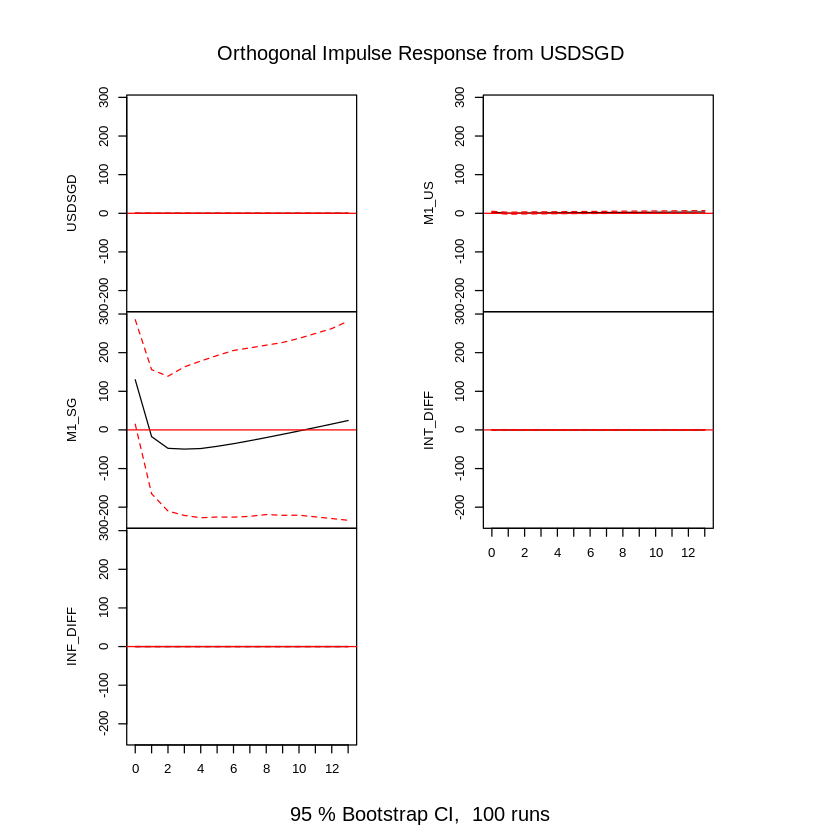

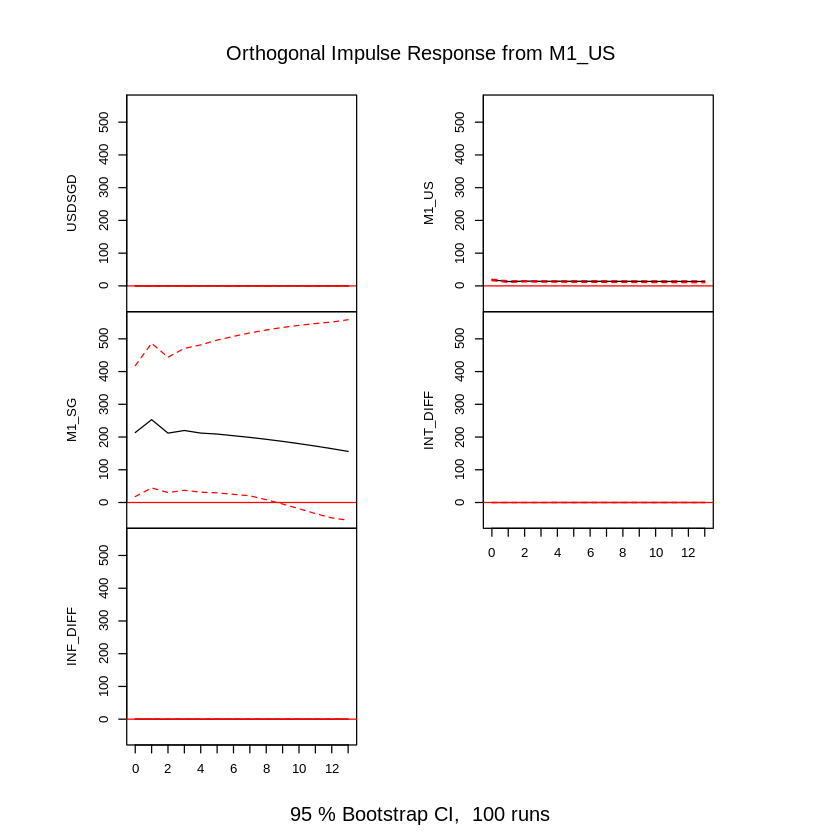

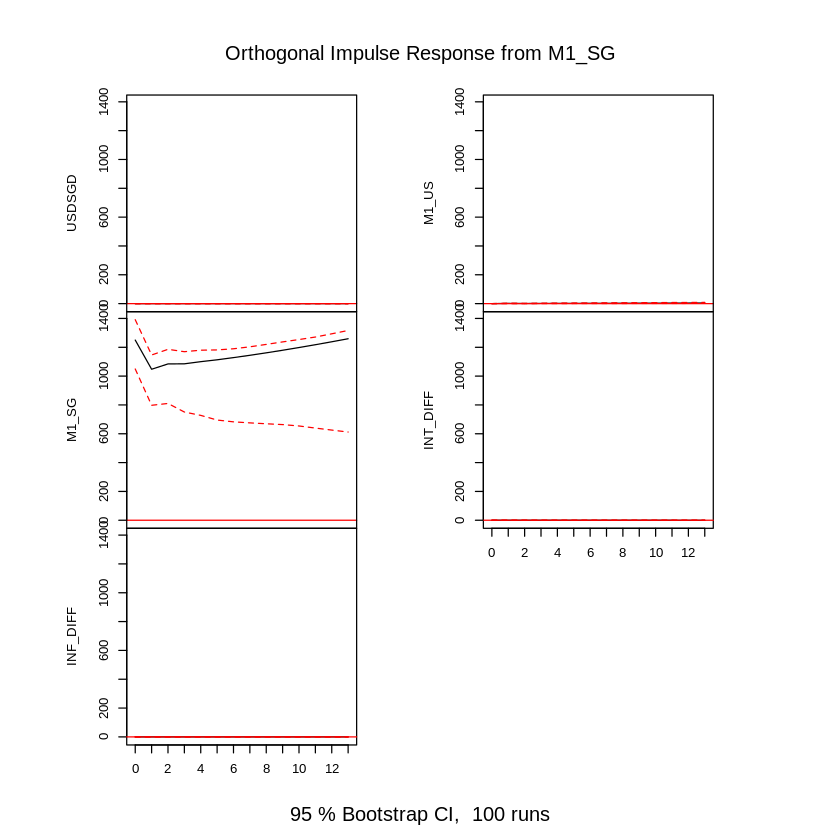

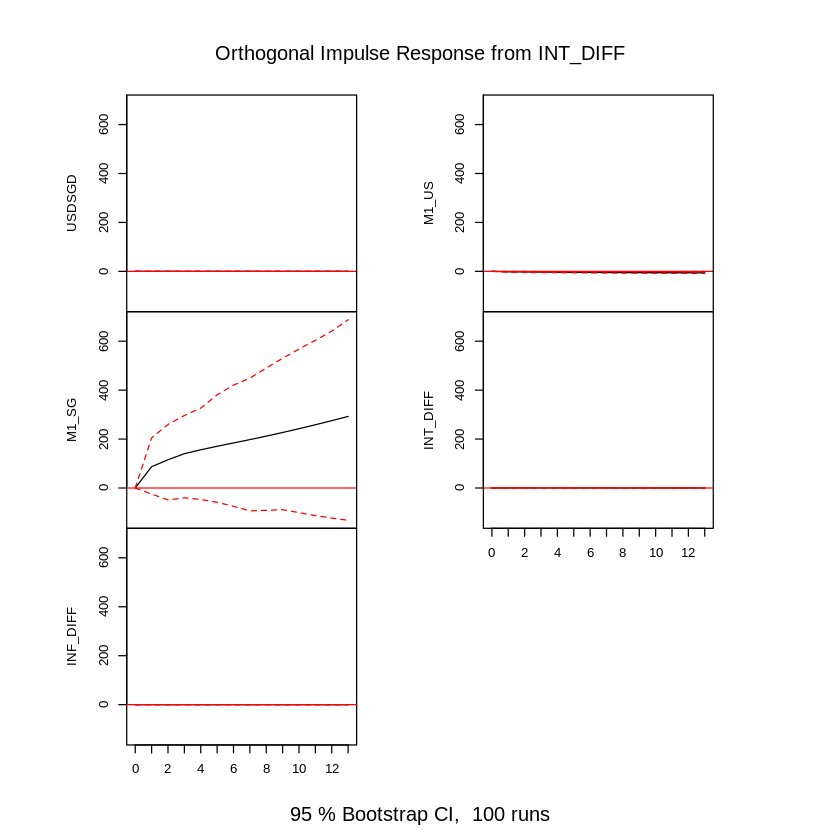

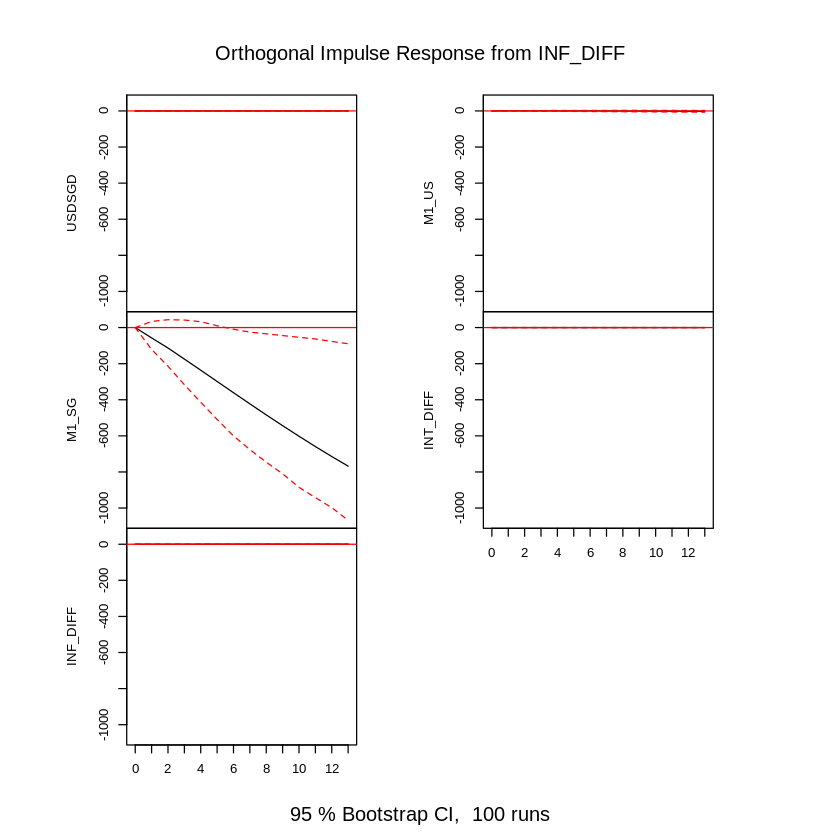

In [13]:
# compute and plot the impulse response functions
VAR_irf = irf(VAR_model, n.ahead = 13,boot = TRUE, ci = 0.95)
plot(VAR_irf)

## References
[1] https://www.khanacademy.org/economics-finance-domain/ap-macroeconomics/every-graph-used-in-ap-macroeconomics/a/the-foreign-exchange-market-model

[2] https://eml.berkeley.edu/~obstfeld/182_sp06/c14.pdf

[3] https://www.investopedia.com/terms/m/m1.asp

[4] [https://www.investopedia.com/trading/factors-influence-exchange-rates/]

[5] https://www.researchgate.net/publication/228258887_Causal_Relationships_between_Industrial_Production_Interest_Rate_and_Exchange_Rate_Evidence_on_India

[6] https://stats.stackexchange.com/questions/77791/why-use-vector-error-correction-model

https://www.researchgate.net/publication/320372110_MODELING_AND_FORECASTING_EXCHANGE_RATES

https://homepage.univie.ac.at/robert.kunst/prog05bihawei.pdf